# Pràctica 4 PLN: pre-processat de text i extracció de característiques
En aquesta pràctica realitzarem la neteja i pre-processat de diferents conjunts de dades de text.\
Després farem una extracció de característiques com a matriu *sparse* i com a vectors de paraules

### Noms:
Introdueix en aquesta cel·la els noms dels dos integrants del grup:\
*Alumne 1* \
*Alumne 2*

## Part 1: conjunt de textos de "mundocine"
En aquest primer conjunt de dades tenim una sèrie de crítiques de pel·lícules de cinema, emmagatzemades en format XML (una crítica per arxiu). Hem preparat una funció de tipus `generator` que processa el directori on estan els arxius de les crítiques i retorna per cada arxiu XML una tupla amb 4 valors:
 - Nom de la pel·lícula (string)
 - Resum breu de la crítica (string)
 - Text de la crítica (*string*)
 - Valoració de la pel·lícula (*int* d'1 a 5)

In [54]:
import os, re
from xml.dom.minidom import parseString

def parse_folder(path):
    """generator that reads the contents of XML files in a folder
    Returns the <body> of the <review> in each XML file.
    XML files encoded as 'latin-1'"""
    for file in sorted([f for f in os.listdir(path) if f.endswith('.xml')],
                        key=lambda x: int(re.match(r'\d+',x).group())):
        with open(os.path.join(path, file), encoding='latin-1') as f:
            doc=parseString(f.read())

            titulo = doc.documentElement.attributes["title"].value

            btxt = ""
            review_bod = doc.getElementsByTagName("body")
            if len(review_bod) > 0:
                for node in review_bod[0].childNodes:
                    if node.nodeType == node.TEXT_NODE:
                        btxt += node.data + " "

            rtxt = ""
            review_summ = doc.getElementsByTagName("summary")
            if len(review_summ) > 0:
                for node in review_summ[0].childNodes:
                    if node.nodeType == node.TEXT_NODE:
                        rtxt += node.data + " "
                        
            rank = int(doc.documentElement.attributes["rank"].value)
            
            yield titulo, rtxt, btxt, rank


### Exercici
Les crítiques es troben en el directori "critiques" (si no tens el directori, descomprimeix l'arxiu "critiques.zip" que s'entrega en el material de la pràctica. \
Càrrega la primera crítica del directori usant el mètode `next` sobre la funció `parse_folder` en l'objecte `critica`. Mostra els seus 4 valors.

In [55]:
critica = next(parse_folder("criticas"))
critica[0]

'La guerra de los mundos'

## Anàlisi exploratòria
Abans de processar el text calcularem una sèrie de paràmetres de cada crítica. \
Per a això processem cada crítica per a i guardarem els resultats en un objecte `DataFrame` de Colles.\
Com a característica de cada crítica extraurem:
- Títol de la pel·lícula
- Longitud (en caràcters) del resum
- Longitud (en caràcters) del text de la crítica
- Puntuació de la crítica

### Exercici
Completa el codi següent per a generar el `DataFrame`

In [56]:
import pandas as pd

#creamos una lista en blanco
datos = list()

#recorremos las críticas y calculamos sus métricas
for c in parse_folder("criticas"):
    datos.append({
        'título': c[0],
        'LongResumen': len(c[1]),
        'LongCritica': len(c[2]),
        'puntuación': c[3]
    })

resumen = pd.DataFrame(datos)

In [57]:
resumen

,título,LongResumen,LongCritica,puntuación
0,La guerra de los mundos,32,2951,1
1,Stars Wars III La venganza de los Sith,30,3954,3
2,Los Increibles,68,2467,5
3,Spiderman 2,45,3403,2
4,La casa de cera,42,1696,2
5,El internado,31,1163,2
6,La llave del mal,36,1781,3
7,May,28,3343,4
8,Cinderella Man,33,2885,2
9,La Novia Cadaver,40,736,3


## Neteja de text
Prepararem aquest conjunt de textos per a entrenar un model per a predir la puntuació de cada crítica a partir del text de la crítica.\
Realitzarem el següent processament:
- Separar el text en *tokens*
- Eliminar els *tokens* de tipus *stop-word*, signes de puntuació o espais
- Convertir les entitats de tipus `PER` al token *persona*
- Lematizar el text

### Exercici
Completa el codi següent per a realitzar aquestes funcions:

In [58]:
import spacy

nlp = spacy.load("es_core_news_md")

#definimos función de normalizado
def normaliza(texto):
    doc = nlp(texto)
    tokens = [t for t in doc if not t.is_punct and not t.is_space and not t.is_stop] #devuelve los tokens que cumplen las condiciones
    palabras = []
    for t in tokens:
        if t.ent_iob_=='B' and t.ent_type_=='PER':
            palabras.append('persona')
        elif t.ent_iob_=='I' and t.ent_type_=='PER':
            continue
        else:
            palabras.append(t.lemma_) #si no es PER añadimos el lema
    salida = ' '.join(palabras) #junta todos los tokens en un string
    
    return salida

Comprova el seu funcionament en la crítica prèviament descarregada (variable `critica`)

In [59]:
normaliza(critica[2])

'gustar cine masa pelicula ver mundo parecer coñazo insufribl porqué prota tonto culo suerte peli lograr vencer convertir listo chorrada comienzo pelicula esfumar arte magia volver maduro inteligente peli Spielberg huir huir dar tiro cabron meter par actor echar él comer aparte niña viejo metido cuerpo niña ver él hablar version original dar él freaks cine creerar gracia nena puta madre causar pavor cria persona maduro horroroso niño niño ver él rol asustar hijo adolescente Cruise subnormal dar él bofetada ver hueso mano persona reflejo denominar manipulacion militar chico matar bicho ningun arma persona loco pensar venir saco quereis decir fanatismo locura alguien querer luchar medio muerte seguro jodar sobremanera pelicula aparecer mongo abuelo familia salir dios viejo aparecer traje domingo maquillada.¿pero sinsorgado faltar persona volver exmujer mundo tranquilos contar peli pasar peli acabar restar misterio bodrio persona paso convertir director efecto especial contar historias?¿n

### Possibles millores sobre el processament
Observem els següents problemes:
- Algunes paraules no se separen correctament perquè en el text original estan unides per signes de puntuació.
- La llista de *stop-words* de spaCy no conté 'a','e','i'.
- Alguns lemes mantenen les majúscules.\

Redefinim la funció de normalització per a corregir això:
- Introduïm un espai després de determinats signes de puntuació (".", "?") perquè la divisió en tokens siga correcta
- Filtrem els *tokens* amb una longitud d'1
- Passem a minúscules el lema de cada token

Completa la funció per a realitzar aquestes correccions:

In [60]:
def normaliza_bis(texto):
    texto = re.sub(r"([?.])", r"\1 ", texto) #añadimos un espacio después de "." y "?"
    doc = nlp(texto)
    tokens = [t for t in doc if not t.is_punct and not t.is_space and not t.is_stop and len(t) > 1] #filtramos los tokens que nos interesan
    palabras = []
    for t in tokens:
        if t.ent_iob_=='B' and t.ent_type_=='PER':
            palabras.append('persona')
        elif t.ent_iob_=='I' and t.ent_type_=='PER':
            continue
        else:
            palabras.append(t.lemma_.lower()) #añadimos lema en minúsculas
    salida = ' '.join(palabras) #junta todos los tokens en un string
    
    return salida

Comprova el seu funcionament en la crítica prèviament descarregada (variable `critica`)

In [61]:
normaliza_bis(critica[2])

'gustar cine masa pelicula ver mundo parecer coñazo insufribl porqué prota tonto culo suerte peli lograr vencer convertir listo chorrada comienzo pelicula esfumar arte magia volver maduro inteligente peli spielberg huir huir dar tiro cabron meter par actor echar él comer aparte niña viejo metido cuerpo niña ver él hablar version original dar él freaks cine creerar gracia nena puta madre causar pavor cria persona maduro horroroso niño niño ver él rol asustar hijo adolescente cruise subnormal dar él bofetada ver hueso mano persona reflejo denominar manipulacion militar chico matar bicho ningun arma persona loco pensar venir saco quereis decir fanatismo locura alguien querer luchar medio muerte seguro jodar sobremanera pelicula aparecer mongo abuelo familia salir dios viejo aparecer traje domingo maquillada sinsorgado faltar persona volver exmujer mundo tranquilos contar peli pasar peli acabar restar misterio bodrio persona paso convertir director efecto especial contar historia disteis n

### Anàlisi morfològica
En una crítica té molta importància els adjectius utilitzats.\
Crea una funció per a filtrar només els adjectius utilitzats en cada crítica (utilitza el lema de cada adjectiu).

In [62]:
def extraer_adj(texto):
    texto = re.sub(r'([?.])', r'\1 ', texto) #separamos . y ?
    doc = nlp(texto)
    tokens = [t.lemma_ for t in doc if t.pos_=='ADJ']
    
    return ' '.join(tokens)

Comprova el seu funcionament en la crítica prèviament descarregada (variable `critica`)

In [63]:
extraer_adj(critica[2])

'insufribl chorrada maduro inteligente solo viejo metido original claro grande igual maduro horroroso adolescente subnormal militar loco seguro viejo sinsorgado solo mejor igual bueno especial dificil sensato chorrada aceptable'

### Processament de tot el conjunt de dades
Aplicarem aquestes funcions en bloc a tot el conjunt de dades. \
En aquesta ocasió, no farem res amb el text normalitzat sinó que només ho aplicarem per a calcular el núm. de paraules i el núm. d'adjectius de cada crítica.

### Exercici
Completa el codi següent:\
Nota: tingues en compte que per a comptar paraules has de dividir el *string* en espais i comptar el núm. d'elements

In [64]:
#creamos una lista en blanco
datos = []

#recorremos las críticas y calculamos sus métricas
for c in parse_folder("criticas"):
    datos.append({
        'título': c[0],
        'LongResumen': len(c[1].split(' ')),
        'LongCritica': len(c[2].split(' ')),
        'NumPalabras': len(normaliza_bis(c[2]).split(' ')),
        'NumAdj': len(extraer_adj(c[2]).split(' ')),
        'puntuación': c[3]
    })

resumen = pd.DataFrame(datos)
resumen

,título,LongResumen,LongCritica,NumPalabras,NumAdj,puntuación
0,La guerra de los mundos,7,569,210,29,1
1,Stars Wars III La venganza de los Sith,9,762,277,50,3
2,Los Increibles,12,464,166,33,5
3,Spiderman 2,10,653,255,37,2
4,La casa de cera,8,314,122,23,2
5,El internado,7,210,81,20,2
6,La llave del mal,9,319,118,23,3
7,May,6,565,223,59,4
8,Cinderella Man,7,493,189,46,2
9,La Novia Cadaver,8,130,48,6,3


## Part 2: Extracció de característiques *sparse*
Anem a calcules les matrius de característiques *bag-of-words* i *tfidf* del conjunt de textos anterior.\
Usarem la llibreria `scikit-learn` per a vectorizar els documents.

In [65]:
#Para no tener que cargar todas las críticas en memoria,
#creamos un generador que devuelve iterativamente el
#texto procesado de cada crítica

def generaCritica(criticas):
    """Función de tipo generator que devuelve el
    texto normalizado de cada crítica.
    Entrada:
    criticas: objeto 'parse_folder' que itera
    sobre el directio de las críticas
    Salida:
    texto normalizado de cada crítica"""
    for c in criticas:
        yield normaliza_bis(c[2])

Comprova el seu funcionament generant el text normalitzat de la primera crítica

In [66]:
next(generaCritica(parse_folder('criticas')))

'gustar cine masa pelicula ver mundo parecer coñazo insufribl porqué prota tonto culo suerte peli lograr vencer convertir listo chorrada comienzo pelicula esfumar arte magia volver maduro inteligente peli spielberg huir huir dar tiro cabron meter par actor echar él comer aparte niña viejo metido cuerpo niña ver él hablar version original dar él freaks cine creerar gracia nena puta madre causar pavor cria persona maduro horroroso niño niño ver él rol asustar hijo adolescente cruise subnormal dar él bofetada ver hueso mano persona reflejo denominar manipulacion militar chico matar bicho ningun arma persona loco pensar venir saco quereis decir fanatismo locura alguien querer luchar medio muerte seguro jodar sobremanera pelicula aparecer mongo abuelo familia salir dios viejo aparecer traje domingo maquillada sinsorgado faltar persona volver exmujer mundo tranquilos contar peli pasar peli acabar restar misterio bodrio persona paso convertir director efecto especial contar historia disteis n

Vectorizem tot el conjunt de dades usant les funcions de `scikit-learn`.\
Aquestes funcions admeten un objecte `generator` com a argument d'entrada.

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

criticas = generaCritica(parse_folder('criticas'))#creamos el objeto generador

BoW_criticas = vect.fit(list(criticas))
BoW_criticas

CountVectorizer()

### Exercici
Genera diferents variants de matrius de característiques per al conjunt de les crítiques. Prova amb:
- Matriu TF-IDF
- Matriu BoW amb unigrames i bigrames
- Matriu TF-IDF eliminant les paraules menys freqüents i les més freqüents (mínim de 2 i màxim de 5 documents)
- Mostra quines són les paraules més freqüents eliminades

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(norm=None, use_idf=True)
criticas = generaCritica(parse_folder('criticas'))
tv_matrix = tv.fit_transform(list(criticas))

In [69]:
#matriz BoW con unigramas y bigramas
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,2))

criticas = generaCritica(parse_folder('criticas'))#creamos el objeto generador

BoW_criticas = vect.fit(list(criticas))
BoW_criticas

CountVectorizer(ngram_range=(1, 2))

In [70]:
#matriz TF-IDF con min_df=1 y max_df=5  SON EL MINIMO DE DOCS EN LOS q aparece y el máximo
tv = TfidfVectorizer(norm=None, use_idf=True, min_df=1, max_df=5)
criticas = generaCritica(parse_folder('criticas'))
tv_matrix = tv.fit_transform(list(criticas))

In [71]:
#palabras más frecuentes a eliminar
#aparecen en el atributo 'stop_words_' del vectorizador
tv.stop_words_

{'acabar',
 'actor',
 'allá',
 'año',
 'cara',
 'casa',
 'cine',
 'contar',
 'convertir',
 'cosa',
 'dar',
 'decir',
 'defraudar',
 'dejar',
 'dios',
 'director',
 'duda',
 'echar',
 'efecto',
 'empezar',
 'encontrar',
 'escena',
 'especial',
 'esperar',
 'film',
 'forma',
 'guión',
 'gustar',
 'haber',
 'hablar',
 'hacer',
 'historia',
 'hora',
 'intentar',
 'interesante',
 'ir',
 'juego',
 'llamar',
 'llegar',
 'lleno',
 'malo',
 'mano',
 'matar',
 'mil',
 'momento',
 'mostrar',
 'muerte',
 'mujer',
 'mundo',
 'niña',
 'niño',
 'obra',
 'ocasión',
 'original',
 'pantalla',
 'papel',
 'parecer',
 'pasar',
 'peli',
 'película',
 'pensar',
 'persona',
 'personaje',
 'poder',
 'poner',
 'principal',
 'protagonista',
 'punto',
 'quedar',
 'querer',
 'representar',
 'salir',
 'seguir',
 'terminar',
 'terror',
 'tiempo',
 'tipo',
 'venir',
 'ver',
 'vida',
 'volver',
 'yo',
 'él',
 'único'}

## Word embeddings
Ara calcularem els *word vectors* de les paraules del nostre conjunt de dades, usant la classe `word2vec` de la llibreria `gensim`.\
Aquesta llibreria accepta com a argument d'entrada un objecte `iterador` que generarà el text pre-processament de la següent crítica en la seqüència.\
Usarem les funcions de pre-processament de la llibreria `gensim`.\
Primer definim un objecte de tipus `iterator` per a recórrer les crítiques. Es diferencia d'un simple `generator` que es pot reiniciar la generació de la seqüència (necessari per al model `word2vec`)

In [72]:
from gensim.utils import simple_preprocess
        
class PreprocesaCriticas(object):
    """Pre-procesa el corpus de críticas con la función 'simple_preprocess'
    de la librería gensim
    Entrada: directorio de críticas
    Salida: iterador sobre las críticas (como lista de tokens)"""
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for c in parse_folder(self.dirname):
            yield simple_preprocess(c[2], deacc=True, min_len=2)

In [73]:
#instanciamos un objeto para nuestro directorio
criticas = PreprocesaCriticas('criticas')

Per a provar el seu funcionament amb la primera crítica el convertim en iterable i usem el mètode `next`

In [74]:
#completar
next(criticas.__iter__())

['cada',
 'vez',
 'me',
 'gusta',
 'menos',
 'el',
 'cine',
 'de',
 'masas',
 'las',
 'peliculas',
 'que',
 'ven',
 'todo',
 'el',
 'mundo',
 'me',
 'parecen',
 'cada',
 'vez',
 'mas',
 'conazo',
 'mas',
 'insufribles',
 'no',
 'se',
 'porque',
 'pero',
 'siempre',
 'el',
 'prota',
 'es',
 'tonto',
 'del',
 'culo',
 'tiene',
 'suerte',
 'al',
 'final',
 'de',
 'la',
 'peli',
 'cuando',
 'ha',
 'logrado',
 'vencer',
 'al',
 'mal',
 'se',
 'convierte',
 'en',
 'listo',
 'las',
 'chorradas',
 'que',
 'hacia',
 'al',
 'comienzo',
 'de',
 'la',
 'pelicula',
 'se',
 'esfuman',
 'como',
 'por',
 'arte',
 'de',
 'magia',
 'se',
 'vuelve',
 'maduro',
 'inteligente',
 'esta',
 'peli',
 'de',
 'spielberg',
 'es',
 'mas',
 'de',
 'lo',
 'mismo',
 'huir',
 'huir',
 'que',
 'no',
 'le',
 'den',
 'ni',
 'un',
 'solo',
 'tiro',
 'ademas',
 'el',
 'cabron',
 'ha',
 'metido',
 'un',
 'par',
 'de',
 'actores',
 'que',
 'es',
 'como',
 'para',
 'echarles',
 'de',
 'comer',
 'aparte',
 'la',
 'nina',
 'una

Al contrari que l'objecte generat amb la funció `generaCriticas` l'objecte de `PreprocesaCriticas` es reinicia cada vegada que iterem. \
Calculem els vectors de paraules de tot el corpus amb el model `word2vec` que accepta com a argument d'entrada un objecte de tipus `iterator` com el creat

In [75]:
#Cálculo de los vectores de palabras
from gensim.models import Word2Vec

model = Word2Vec(list(criticas), #iterador con los documentos
                               vector_size=10,          #tamaño del vector
                               window=5,         #nº de términos adyacentes que usamos para el cálculo
                               min_count=5,      #nº mínimo de apariciones del término para contarlo
                               epochs=100
                              )

#una vez entrenado el modelo nos quedamos con los vectores calculados
#si no se van a actualizar los vectores con nuevos documentos
model = model.wv
len(model.key_to_index)

317

Seleccionem aleatòriament 25 paraules del conjunt calculat

In [76]:
import numpy as np

palabras_sample = np.random.choice(model.index_to_key, 25, replace=True)

In [77]:
palabras_sample

array(['cuando', 'jedi', 'porque', 'sabe', 'serie', 'punto', 'hasta',
       'ellos', 'aunque', 'lleno', 'ninguna', 'muy', 'cinta', 'para',
       'mil', 'visto', 'aun', 'puta', 'duda', 'mendes', 'cosa', 'cierto',
       'seria', 'pone', 'sus'], dtype='<U13')

### Exercici
Comprova com funciona el model buscant les paraules més similars semànticament a "trama", "peli" i "pelicula"

In [78]:
model.most_similar('trama')#palabras similares a 'trama'

[('nos', 0.8516148924827576),
 ('ritmo', 0.8267508149147034),
 ('quizas', 0.8180763721466064),
 ('con', 0.7836773991584778),
 ('nunca', 0.7775316834449768),
 ('hubiera', 0.7615916132926941),
 ('siempre', 0.7612186074256897),
 ('muestra', 0.7537740468978882),
 ('interesantes', 0.7443342804908752),
 ('muerte', 0.7432039380073547)]

In [79]:
model.most_similar('peli')#palabras similares a 'peli'

[('comienzo', 0.9117603898048401),
 ('mal', 0.7954180836677551),
 ('mucha', 0.7935699224472046),
 ('terror', 0.7916178703308105),
 ('tu', 0.7892953157424927),
 ('pone', 0.7661665678024292),
 ('entre', 0.7586406469345093),
 ('dar', 0.7556861639022827),
 ('puta', 0.7400146126747131),
 ('esta', 0.7350733280181885)]

In [80]:
model.most_similar('pelicula')#palabras similares a 'pelicula'

[('dios', 0.85880047082901),
 ('antes', 0.7968642711639404),
 ('mala', 0.7753196954727173),
 ('viene', 0.7483215928077698),
 ('dejar', 0.6993259787559509),
 ('serie', 0.6873698234558105),
 ('vamos', 0.6813944578170776),
 ('sobre', 0.6640903353691101),
 ('todas', 0.6568434834480286),
 ('sigue', 0.6494836211204529)]

### Exercici
Veurem la influència del preprocessament. Per a això alimentarem el model amb les crítiques *preprocesadas amb la funció de normalització sobre `spaCy` (que produeix text lematizat i amb un altre filtrat).\
Per a això cal re-definir l'objecte `iterador` sobre el corpus.

In [81]:
#comparamos con un modelo que use el preprocesado de spaCy
        
class PreprocesaCriticasSpacy(object):
    """Pre-procesa el corpus de críticas con la función de normalización
    definida con la librería spaCy
    Entrada: directorio de críticas
    Salida: iterador sobre las críticas (como lista de tokens)"""
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for c in parse_folder(self.dirname):
            yield nlp.make_doc(c[2])

### Exercici
Instància aquesta nova classe per al directori de les crítiques en l'objecte `critiques_spacy` i comprova el seu funcionament sobre la primera crítica

In [82]:
criticas_spacy = PreprocesaCriticasSpacy('criticas')

In [83]:
next(criticas_spacy.__iter__())#prueba a generar la primera crítica

Cada vez me gusta menos el cine de masas. Las peliculas que ven todo el mundo me parecen cada vez mas coñazo y mas insufribles. No se porqué pero siempre el prota es tonto del culo y tiene suerte, y al final de la peli, cuando ha logrado vencer al mal, se convierte en listo, y las chorradas que hacia al comienzo de la pelicula se esfuman como por arte de magia. Se vuelve maduro e inteligente.Esta peli de Spielberg es mas de lo mismo, huir y huir y que no le den ni un solo tiro. Además el cabron ha metido a un par de actores que es como para echarles de comer aparte. La niña, una vieja metida en el cuerpo de una niña, porque solo hay que verle hablar (en version original claro) para darse cuenta que estamos ante uno de los grandes freaks del cine. Se creeran que hace gracia la nena cuando habla igual que su puta madre, pero a mi me causa pavor. Ver a una cria que habla como una persona madura es algo horroroso. Los niños son niños y verlos fuera de su rol asusta.Luego esta el hijo adole

Calcula el model de vectors de paraules amb aquest nou *pre-processat

In [115]:
modelSpacy = Word2Vec(list(criticas_spacy), #iterador con los documentos
                               vector_size=10,          #tamaño del vector
                               window=5,         #nº de términos adyacentes que usamos para el cálculo
                               min_count=5,      #nº mínimo de apariciones del término para contarlo
                               epochs=100
                              )

#una vez entrenado el modelo nos quedamos con los vectores calculados
#si no se van a actualizar los vectores con nuevos documentos
modelSpacy = modelSpacy.wv
len(modelSpacy.vocab)

RuntimeError: you must first build vocabulary before training the model

### Pregunta
per què el nou model té un vocabulari amb molts menys termes que el model anterior?

### Visualització de word vectors
Usem una reducció de dimensionalitat t-SNE per a visualitzar un grup de paraules

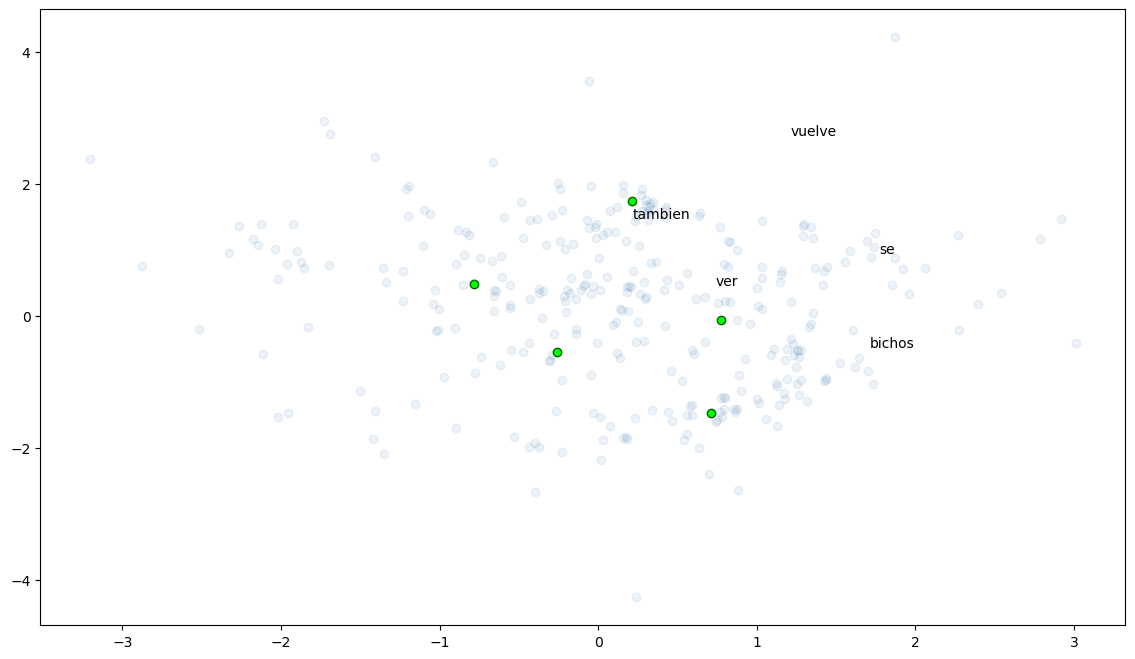

In [92]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

palabras_vectors = model[model.index_to_key]

#seleccinamos unos pocos términos para visualizarlos entre el conjunto
random_idx = np.random.randint(len(model.index_to_key), size=5)

tsne = TSNE(n_components=2, random_state=0, n_iter=250, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(palabras_vectors)

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', alpha=0.1)

labels = np.array(model.index_to_key)[random_idx]


T_labels = T[random_idx,:]

plt.scatter(T_labels[:, 0], T_labels[:, 1], c='lime', edgecolors='darkgreen')
for label, x, y in zip(labels, T_labels[:, 0], T_labels[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [93]:
labels

array(['se', 'tambien', 'ver', 'bichos', 'vuelve'], dtype='<U13')

Ara carregarem els vectors per a les mateixes paraules amb el model pre-entrenat GloVe de `spaCy` per a comparar

In [99]:
palabras_vectors = [nlp.vocab[t].vector for t in model.index_to_key]

tsne = TSNE(n_components=2, random_state=0, n_iter=250, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(palabras_vectors)

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', alpha=0.1)

labels = np.array(model.index_to_key)[random_idx]


T_labels = T[random_idx,:]

plt.scatter(T_labels[:, 0], T_labels[:, 1], c='lime', edgecolors='darkgreen')
for label, x, y in zip(labels, T_labels[:, 0], T_labels[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

AttributeError: 'list' object has no attribute 'shape'

## Part 3: Conjunt de Tuits en espanyol
Anem a pre-processar un conjunt de tuits en espanyol etiquetatges amb la seua polaritat

In [108]:
pd.set_option('display.max_colwidth', None)

# Leemos los datos
df = pd.read_csv('tweets_all.csv', index_col=None)

df.head()

,content,polarity
0,"-Me caes muy bien \r\n-Tienes que jugar más partidas al lol con Russel y conmigo\r\n-Por qué tan Otako, deja de ser otako\r\n-Haber si me muero",NONE
1,"@myendlesshazza a. que puto mal escribo\r\n\r\nb. me sigo surrando help \r\n\r\n3. ha quedado raro el ""cómetelo"" ahí JAJAJAJA",N
2,@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero,N
3,Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps,P
4,Vale he visto la tia bebiendose su regla y me hs dado muchs grima,N


### Exercici
Defineix una funció de normalització que faça les següents tasques:
- Eliminar esments i URL mitjançant un patró RegEx
- Separar el text en *tokens* convertint-los a minúscules, eliminant els que siguen signes de puntuació, espais o dígits
- Eliminar els stop-words d'una llista pròpia passada com a argument
- Eliminar els símbols de puntuació dels tokens (etiquetes, admiracions, etc.)
- Eliminar els tokens d'una longitud menor de 2

In [120]:
import string
#lista de stop-words específicos de nuestro corpus (aproximación)
stop_words = ['los', 'pero', 'por', 'que', 'una']

patron = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, stop_words=stop_words):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Dejamos tokens en minúsculas.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[^ ]+', r'', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [token for token in tokens if not token.is_punct and not token.is_space and not token.is_digit] #filtra tokens (puntuaciones, espacios y dígitos)
    filtered_tokens = [token for token in tokens if not token.is_stop and len(token) >= 2 and token.is_alpha] #limpia tokens (signos de puntuación, stop-words y longitud<2)
    filtered_text = ' '.join([token.text for token in filtered_tokens]) #juntam,os como string
    
    return filtered_text

Aplica la funció a tots els tuits (columna 'content') creant una nova columna 'net' del dataframe

In [121]:
df['limpio'] = [clean_text(text) for text in df['content']]

In [122]:
df.head()

,content,polarity,limpio
0,"-Me caes muy bien \r\n-Tienes que jugar más partidas al lol con Russel y conmigo\r\n-Por qué tan Otako, deja de ser otako\r\n-Haber si me muero",NONE,caes jugar partidas lol Russel Otako deja otako muero
1,"@myendlesshazza a. que puto mal escribo\r\n\r\nb. me sigo surrando help \r\n\r\n3. ha quedado raro el ""cómetelo"" ahí JAJAJAJA",N,puto escribo sigo surrando help quedado raro cómetelo JAJAJAJA
2,@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero,N,jajajaja gente seguro melena muero
3,Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps,P,Quiero mogollón sobretodo rápido contesta wasaps
4,Vale he visto la tia bebiendose su regla y me hs dado muchs grima,N,Vale visto tia bebiendose regla hs muchs grima
